Working through the lab at https://colab.research.google.com/drive/1gc6u6hItUKY9uJt6GXHaneSYCMaGcxp1#scrollTo=XLyVPuLXSagK

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [26]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

In [5]:
BOMBING_PATH = os.path.join('..', 'data', 'Bombing_Operations.json.gz')
AIRCRAFT_PATH = os.path.join('..', 'data', 'Aircraft_Glossary.json.gz')

Bombing_Operations = spark.read.json(BOMBING_PATH)
Aircraft_Glossary = spark.read.json(AIRCRAFT_PATH)

In [6]:
Bombing_Operations.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)



In [7]:
Aircraft_Glossary.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)



In [8]:
Bombing_Operations.take(3)

[Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1971-06-05', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='TAN SON NHUT', TargetCountry='CAMBODIA', TimeOnTarget=1005.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1972-12-26', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='NAKHON PHANOM', TargetCountry='SOUTH VIETNAM', TimeOnTarget=530.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='RF-4', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1973-07-28', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='UDORN AB', TargetCountry='LAOS', TimeOnTarget=730.0, WeaponType=None, WeaponsLoadedWeight=0)]

In [9]:
Aircraft_Glossary.show()

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

In [10]:
print(f"In total, there are {Bombing_Operations.count()} operations.")

In total, there are 4400775 operations.


## Question 1: Which countries are involved and in how many missions?

Keywords: Dataframe API, SQL, group by, sort

In [11]:
Bombing_Operations.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              null|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                null|                  0|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              null|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                null|                  0|
|    RF-4|UNITED STATES OF ...| 1973-07-28|              null|          D|       UDORN AB|         LAOS|       730.0|                null|                  0|
|     A-1|UNITED STATES OF ...| 1970-02-02|   

In [18]:
country_mission_counts = Bombing_Operations.groupBy('ContryFlyingMission').agg(count('*').alias('CountryMissionCount'))

In [19]:
country_mission_counts.show()

+--------------------+-------------------+
| ContryFlyingMission|CountryMissionCount|
+--------------------+-------------------+
|     VIETNAM (SOUTH)|             622013|
|       KOREA (SOUTH)|              24469|
|UNITED STATES OF ...|            3708997|
|           AUSTRALIA|              12519|
|                LAOS|              32777|
+--------------------+-------------------+



In [21]:
country_mission_counts = country_mission_counts.sort(desc('CountryMissionCount'))

In [22]:
country_mission_counts.show()

+--------------------+-------------------+
| ContryFlyingMission|CountryMissionCount|
+--------------------+-------------------+
|UNITED STATES OF ...|            3708997|
|     VIETNAM (SOUTH)|             622013|
|                LAOS|              32777|
|       KOREA (SOUTH)|              24469|
|           AUSTRALIA|              12519|
+--------------------+-------------------+



In [23]:
country_mission_counts_df = country_mission_counts.toPandas()

Text(0, 0.5, 'Missions Flown')

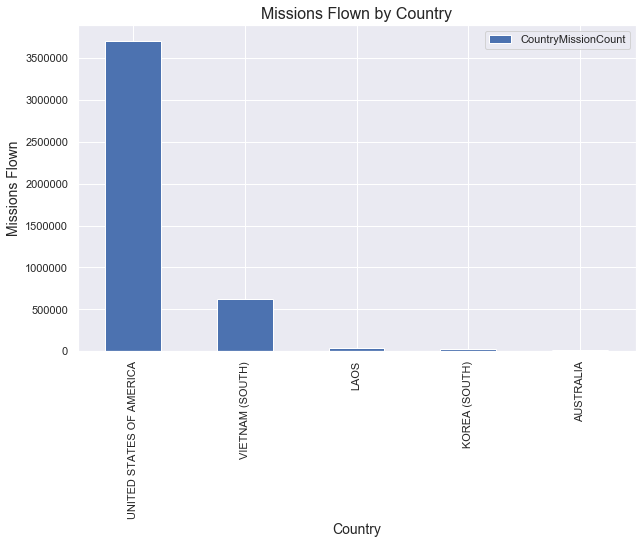

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
country_mission_counts_df.plot(kind='bar', x='ContryFlyingMission', y='CountryMissionCount', ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_title('Missions Flown by Country', fontsize=16)
ax.set_xlabel('Country', fontsize=14)
ax.set_ylabel('Missions Flown', fontsize=14)


## Questions 2: Show the number of missions in time for each of the countries involved.

In [ ]:
Bombing_Operations

In [ ]:
country_mission_counts = Bombing_Operations.groupBy('ContryFlyingMission').agg(count('*').alias('CountryMissionCount'))

In [62]:
missions_per_day_by_ctry = Bombing_Operations.select(to_date('MissionDate').alias('MissionDate'), 'ContryFlyingMission')
missions_per_day_by_ctry = missions_per_day__by_ctry.groupBy(['MissionDate', 'ContryFlyingMission']).agg(count('*').alias('MissionCount'))
missions_per_day_by_ctry = missions_per_day__by_ctry.sort(asc('MissionDate'))
missions_per_day_by_ctry.show()

+-----------+--------------------+--------+
|MissionDate| ContryFlyingMission|count(1)|
+-----------+--------------------+--------+
| 1965-10-01|UNITED STATES OF ...|     447|
| 1965-10-02|UNITED STATES OF ...|     652|
| 1965-10-03|UNITED STATES OF ...|     608|
| 1965-10-04|UNITED STATES OF ...|     532|
| 1965-10-05|     VIETNAM (SOUTH)|      72|
| 1965-10-05|UNITED STATES OF ...|     697|
| 1965-10-06|     VIETNAM (SOUTH)|      49|
| 1965-10-06|UNITED STATES OF ...|     689|
| 1965-10-07|     VIETNAM (SOUTH)|      50|
| 1965-10-07|UNITED STATES OF ...|     605|
| 1965-10-08|     VIETNAM (SOUTH)|      64|
| 1965-10-08|UNITED STATES OF ...|     700|
| 1965-10-09|UNITED STATES OF ...|     677|
| 1965-10-09|     VIETNAM (SOUTH)|      69|
| 1965-10-10|UNITED STATES OF ...|     789|
| 1965-10-10|     VIETNAM (SOUTH)|      59|
| 1965-10-11|     VIETNAM (SOUTH)|      48|
| 1965-10-11|UNITED STATES OF ...|     455|
| 1965-10-12|UNITED STATES OF ...|     449|
| 1965-10-12|     VIETNAM (SOUTH

In [63]:
missions_per_day_by_ctry_df = missions_per_day_by_ctry.toPandas()

In [64]:
missions_per_day_by_ctry_df.head(2)

,MissionDate,ContryFlyingMission,count(1)
0,1965-10-01,UNITED STATES OF AMERICA,447
1,1965-10-02,UNITED STATES OF AMERICA,652


In [66]:
fig = plt.figure(figsize=(10, 6))

# iterate the different groups to create a different series
for country, missions in missions_per_day_by_ctry_df.groupby("ContryFlyingMission"): 
    plt.plot(missions["MissionDate"], missions["MissionCount"], label=country)

plt.legend(loc='best')

KeyError: 'MissionCount'

<Figure size 720x432 with 0 Axes>